# Multi-Layer Perceptron for a toy two-class problem in PyTorch

Markus Enzweiler, markus.enzweiler@hs-esslingen.de

This is a demo used in a Computer Vision & Machine Learning lecture. Feel free to use and contribute.

We build and train a multi-layer perceptron (MLP) for a two-class classification problem with a *single* neuron in its output layer. The MLP will output values from 0-1 and we can use a threshold of 0.5 to determine the class label.

We will also train a single perceptron for comparison. 



See https://pytorch.org/docs/stable/nn.html and in particular:
- https://pytorch.org/docs/stable/generated/torch.nn.Module.html  
- https://pytorch.org/docs/stable/generated/torch.nn.Linear.html 

## Setup

Adapt `packagePath` to point to the directory containing this notebeook.

In [1]:
# Notebook id
nb_id = "multi_layer_perceptron/torch"

# Imports
import sys
import os

In [2]:
# Package Path (folder of this notebook)

#####################
# Local environment #
#####################

package_path = "./"


#########
# Colab #
#########


def check_for_colab():
  try:
      import google.colab
      return True
  except ImportError:
      return False

# running on Colab?
on_colab = check_for_colab()

if on_colab:

    # assume this notebook is run from Google Drive and the whole
    # cv-ml-lecture-notebooks repo has been setup via setupOnColab.ipynb

    # Google Drive mount point
    gdrive_mnt = '/content/drive'

    ##########################################################################
    # Ensure that this is the same as gdrive_repo_root in setupOnColab.ipynb #
    ##########################################################################
    # Path on Google Drive to the cv-ml-lecture-notebooks repo
    gdrive_repo_root = f"{gdrive_mnt}/MyDrive/cv-ml-lecture-notebooks"

    # mount drive
    from google.colab import drive
    drive.mount(gdrive_mnt, force_remount=True)

    # set package path
    package_path = f"{gdrive_repo_root}/{nb_id}"

# check whether package path exists
if not os.path.isdir(package_path):
  raise FileNotFoundError(f"Package path does not exist: {package_path}")

print(f"Package path: {package_path}")


Package path: ./


In [3]:
# Additional imports

# Repository Root
repo_root = os.path.abspath(os.path.join(package_path, "..", ".."))
# Add the repository root to the system path
if repo_root not in sys.path:
    sys.path.append(repo_root)

# Package Imports
from nbutils import requirements as nb_reqs
from nbutils import colab as nb_colab
from nbutils import git as nb_git
from nbutils import exec as nb_exec
from nbutils import data as nb_data

In [4]:
# Install requirements in the current Jupyter kernel
req_file = os.path.join(package_path, "requirements.txt")
nb_reqs.pip_install_reqs(req_file, on_colab)

['/Users/menzweil/Development/miniforge3/envs/pytorch-m1-2023-10/bin/python', '-m', 'pip', 'install', '-r', './requirements.txt']


In [5]:
# Now we should be able to import the additional packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Set the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42);


## Create the training and validation data

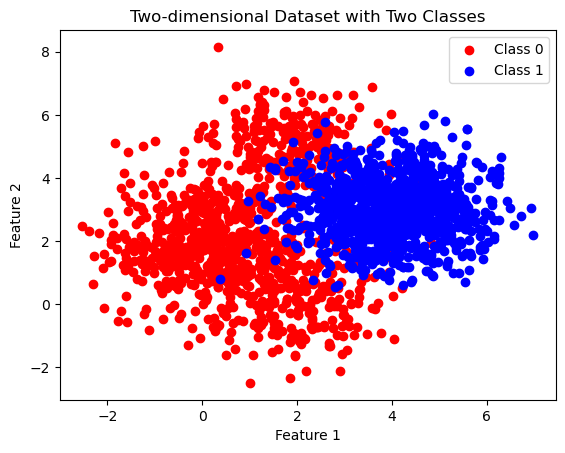

In [6]:
# Number of samples per class
n_samples = 1000

# Generate random data for class 1
class_0 = torch.cat([
    torch.randn(n_samples//4, 2) + torch.tensor([2, 0]),
    torch.randn(n_samples//2, 2) + torch.tensor([0, 2]),
    torch.randn(n_samples//4, 2) + torch.tensor([2, 5])
    ])


# Generate random data for class 2
class_1 = torch.randn(n_samples, 2) + torch.tensor([4, 3])

# Labels for the classes
labels_0 = torch.zeros(n_samples, 1)
labels_1 = torch.ones(n_samples, 1)

# Combine the data and labels
data   = torch.cat([class_0, class_1],   dim=0)
labels = torch.cat([labels_0, labels_1], dim=0)

# Plotting the data
plt.scatter(class_0[:, 0], class_0[:, 1], color='red', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='blue',  label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Two-dimensional Dataset with Two Classes')
plt.legend()
plt.show()

In [7]:
# Split the data into training and validation data sets
# and wrap them in a Dataloader

from torch.utils.data import TensorDataset, DataLoader, random_split

# Combine data and labels into a dataset
dataset = TensorDataset(data, labels)

# Define the size of the training and validation sets
train_size = int(0.8 * len(dataset))    # 80% for training
val_size   = len(dataset) - train_size  # 20% for validation

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# You can also create DataLoader for batching if needed
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=True)

# Now, train_loader and val_loader can be used in a training loop

# Define the Multi-Layer Perceptron (MLP) and a single Perceptron

## Single perceptron class

In [8]:
# Perceptron model
class Perceptron(nn.Module):
    def __init__(self, num_inputs):
        super().__init__()
        self.linear = nn.Linear(num_inputs, 1)
        self.sigmoid = nn.Sigmoid()

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        return self.sigmoid(self.linear(x))

## MLP class

In [9]:
# Multi-layer perceptron model
class MultiLayerPerceptron(nn.Module):
    def __init__(self, num_inputs, num_hidden_layer_neurons=2):
        super().__init__()

        # layer 1 defines the transformation from input to hidden layer
        self.layer1 = nn.Linear(num_inputs, num_hidden_layer_neurons)
        # layer 2 defines the transformation from hidden layer to output
        self.layer2 = nn.Linear(num_hidden_layer_neurons, 1)
        # sigmoid activation function
        self.sigmoid = nn.Sigmoid()

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        # x (input) -> hidden layer -> sigmoid -> output layer -> sigmoid
        x = self.sigmoid(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x
    

# Training with gradient descent

## Training and testing functions

In [10]:
# Training function 
def train(model, train_loader, optimizer, loss_fn, num_epochs):
    
    # Loop over epochs
    for epoch in range(num_epochs):

        # reset accumulated loss
        acc_loss = 0.0

        for data in train_loader:
    
            # training sample and label
            x,y = data

            # forward pass
            y_hat = model(x)

            # backward pass
            loss = loss_fn(y_hat, y)
            loss.backward()
            
            # accumulate loss
            acc_loss += loss

            # Update weights and bias
            optimizer.step()
            optimizer.zero_grad()
        

        # Print accumulated average loss per epoch once in a while
        if (epoch % (num_epochs//10)) == 0 or epoch == num_epochs - 1:     
            print(f"Epoch {epoch:5d}: loss = {torch.mean(acc_loss):.5f}")

In [11]:
# Testing function

# The model will output values from 0-1.
# We can use a threshold of 0.5 to determine the class label.

def test(model, val_loader):
    # test the model on all data points
    print("Testing ...")

    num_correct = 0

    for data in val_loader:  
        x,y = data
        prediction = model(x)
        class_label = torch.where(prediction < 0.5, torch.tensor(0), torch.tensor(1))
        print(f"{x} -> {class_label} ({prediction.item():.3f}) (label: {y})")

        if class_label == y:
            num_correct += 1
    
    # Print accuracy
    print(f"Accuracy: {num_correct}/{val_size} = {100 * num_correct/val_size:.2f}%")
    

In [12]:
# Visualization

import matplotlib.cm as cm
import matplotlib.gridspec as gridspec


def show_decision_boundary(model, data, labels, subplot_spec=None):

    data   = data.numpy()
    labels = labels.numpy()

    wratio = (15, 1)
    if subplot_spec is None:
        gs = gridspec.GridSpec(1, 2, width_ratios=wratio)
    else:
        gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=subplot_spec, width_ratios=wratio)
        
    ax = plt.subplot(gs[0])
    ax.set_title('Dataset and decision function')
    
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    h = 0.01  # Reduced step size for higher resolution
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
    Z = Z.reshape(xx.shape)

    # Increase the number of levels for smoother color transitions
    levels = np.linspace(0, 1, 100)
    ctr = ax.contourf(xx, yy, Z.detach().numpy(), levels, cmap=cm.gray, vmin=0, vmax=1)
    
    unique_labels = np.unique(labels)

    # Define colors for each class
    colors = ['red', 'blue']
    for i, yi in enumerate(unique_labels):
        color = colors[i]
        ax.scatter(data[np.where(labels.flatten() == yi), 0], data[np.where(labels.flatten() == yi), 1], 
                   color=color, linewidth=0, label='Class %d (y=%d)' % (yi, yi))
    ax.legend()
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))

    # Create colorbar
    cbar = plt.colorbar(ctr, cax=plt.subplot(gs[1]))
    cbar.set_ticks(np.arange(0, 1.1, 0.1))  # Set ticks from 0 to 1 with 0.1 increments
    cbar.set_label('Decision value')

## Train and test the single perceptron

In [13]:
# Train the perceptron model

# The model to train
model = Perceptron(num_inputs=2)

# Hyperparameters
num_epochs = 50
eta = 0.01

# Stochastic gradient descent (SGD) optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=eta)

# We can use L2 (mean squared error) loss from PyTorch
loss_fn = nn.MSELoss()

# Train the model
train(model, train_loader, optimizer, loss_fn, num_epochs)

Epoch     0: loss = 248.49179


Epoch     5: loss = 151.49380
Epoch    10: loss = 136.77972
Epoch    15: loss = 131.42142
Epoch    20: loss = 129.00381
Epoch    25: loss = 127.16821
Epoch    30: loss = 126.51196
Epoch    35: loss = 125.55305
Epoch    40: loss = 124.69627
Epoch    45: loss = 123.90467
Epoch    49: loss = 124.51131


In [14]:
# Test the model
test(model, val_loader)

Testing ...
tensor([[4.9313, 3.1128]]) -> tensor([[1]]) (0.987) (label: tensor([[1.]]))
tensor([[3.2477, 2.5231]]) -> tensor([[1]]) (0.781) (label: tensor([[1.]]))
tensor([[2.4866, 0.3668]]) -> tensor([[0]]) (0.403) (label: tensor([[0.]]))
tensor([[4.0080, 2.7165]]) -> tensor([[1]]) (0.933) (label: tensor([[1.]]))
tensor([[3.2337, 4.4586]]) -> tensor([[1]]) (0.823) (label: tensor([[1.]]))
tensor([[ 3.0554, -1.4534]]) -> tensor([[1]]) (0.584) (label: tensor([[0.]]))
tensor([[1.8455, 3.3987]]) -> tensor([[0]]) (0.255) (label: tensor([[0.]]))
tensor([[4.9172, 2.4771]]) -> tensor([[1]]) (0.985) (label: tensor([[1.]]))
tensor([[6.9807, 2.1908]]) -> tensor([[1]]) (1.000) (label: tensor([[1.]]))
tensor([[ 2.4038, -0.7140]]) -> tensor([[0]]) (0.332) (label: tensor([[0.]]))
tensor([[ 1.6864, -0.1293]]) -> tensor([[0]]) (0.133) (label: tensor([[0.]]))
tensor([[-1.6171,  1.6410]]) -> tensor([[0]]) (0.001) (label: tensor([[0.]]))
tensor([[-0.0966,  3.5419]]) -> tensor([[0]]) (0.011) (label: tensor

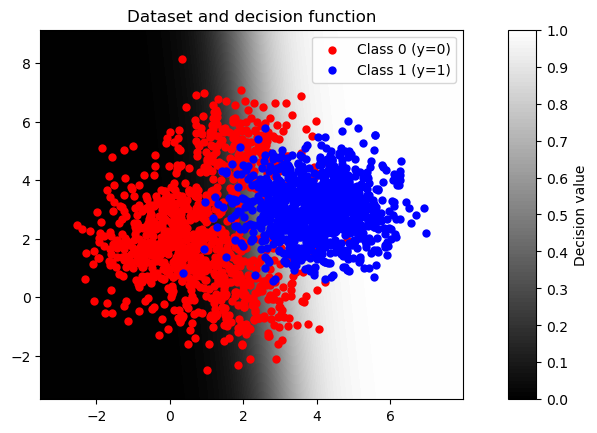

In [15]:
# Visualize the decision boundary
show_decision_boundary(model, data, labels)

## Train and test the MLP

In [16]:
# Train the MLP model

# The model to train
model = MultiLayerPerceptron(num_inputs=2)

# Hyperparameters
num_epochs = 50
eta = 0.01

# Stochastic gradient descent (SGD) optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=eta)

# We can use L2 (mean squared error) loss from PyTorch
loss_fn = nn.MSELoss()

# Train the model
train(model, train_loader, optimizer, loss_fn, num_epochs)

Epoch     0: loss = 383.73563
Epoch     5: loss = 195.21060
Epoch    10: loss = 147.07477
Epoch    15: loss = 118.89775


In [ ]:
# Test the model
test(model, val_loader)

In [ ]:
# Visualize the decision boundary
show_decision_boundary(model, data, labels)